# OpenStreetMap Data Case Study<a class="tocSkip">

**[Courtney Ferguson Lee](https://www.linkedin.com/in/courtneyfergusonlee/)**

*April 11, 2017*

This report is an overview of the process I went through when cleaning and contributing to the OpenStreetMap project. If you're curious about the detailed code I used to process, clean and convert the XML files into a relational SQL database, please checkout my [cleaning notebook](https://github.com/spacecadet84/p3/blob/master/cleaning_notebook.ipynb), found on my [github](https://github.com/spacecadet84).

# Region

**[West Springfield, Massachusetts](https://en.wikipedia.org/wiki/West_Springfield,_Massachusetts)**: This is my hometown. I was interested in all the nooks and crannies of the town I've lived in for the past 9 years. How many parks are there? Are there any hidden gem restaurants I've missed? This project helped me develop a lot of the data cleaning skills I use every day.

**[Dataset](https://www.openstreetmap.org/relation/1181623)**: This is the XML dataset that I cleaned using Python and SQL.



<img src='https://drive.google.com/uc?export=download&id=0B0YVy8F1XohwOVEtMmExY1FXUkE'>

# Process Overview

1. Create a smaller file to test
2. Clean the data
 1. Check for problem characters in each tag
 2. Clean up overabbreviated street names
 3. Fix incorrect zip codes
 4. Standardize phone numbers
3. Convert from xml to csv
4. Import the cleaned .csv into a SQL database
5. Explore the database through queries
6. Document

# Cleaning the Data

Cleaning the data consisted of multiple stages.  The first involved checking all tags for problem characters, then diving deeper into individual tags to make the data more uniform.  Problems can be broken down into the following categories:

- Problem characters: (\$, ?, #, &, etc)
- Fixing Street Type Abbreviations (Main St, East Mountain Rd)
 - 'addr:street' tags
 - 'name' tags
- Incorrect Zip Codes (Springfield MA 00, West Springfield MA 00)
 - 'address' tags
 - 'postcode' tags
- Non-uniform Phone Numbers (+1 413 3063051, +1  413 5920396)
 - 'phone' tags

## Checking for problem characters

This was the first check before cleaning any data.  It helped thinking of this as the first layer in the process.  By eliminating any problem characters first, I could focus on making the remaining data uniform.

In [ ]:
# Checks whether there are problem characters present
def is_problem_char(attribute):
    m = PROBLEMCHARS.search(attribute)
    return m

## Fixing Street Type Abbreviations

### Addr: Street Tags

This was the first tag type I explored.  Initially I thought all street names would be found here, but initial queries only yielded a few dozen names.  Cleaning up these tags did help me develop a systematic way to clean up subsequent tags, though.  The first thing I did was to audit all 'addr:street' tags to look for any unusual street abbreviations.

In [ ]:
# Checks if it's an 'addr:street' tag
if is_street_name(tag):
    #print "Old value: " + way_tag['value']
    way_tag['value'] = update_name(way_tag['value'], mapping)
    #print "New value: " + way_tag['value']


I created a dictionary using the street type (Ave, Avenue, Rd, etc) as the key and the specific instance as the value.  I used a regular expression to search for and pull the street type and then I used another regular expression to substitute the proper mapping.  Looking at the data like this helped me develop a plan to map the data and correct any abbreviations.

The audit and update process helped me capture problematic addresses in a more complete and systematic way.  It also tested my regular expression skills!

In [ ]:
def audit_street_type(street_types, street_name):
    m = street_type_re.search(street_name)
    if m:
        street_type = m.group()
        if street_type not in expected:
            street_types[street_type].add(street_name)


In [ ]:
def update_name(name, mapping):
    
    updated_name = name
    
    split_name = re.split(' ', name)
    for nm in split_name:
        if nm in mapping:
            updated_name = re.sub(nm, mapping[nm], updated_name)
    
    return updated_name

### Street Name Tags

Cleaning up street names turned out to be more difficult than expected.  This is because not all street names were stored under the same keys.  Some were stored under 'addr:street' tags, but the vast majority used a combination of 'highway' and 'name' tags.  I couldn't just pull all ways tags with 'name' for a key.  The 'name' tag was also used to identify buildings, parks, etc.  

One thing all streets had in common, however was that they had a highway tag. Because tags were parsed iteratively, once a 'name' tag was found I had to loop back to check if there was a 'highway' tag present.  

I'm not sure why they chose to map the data like this.  They may have started with one method, but switched over to a different mapping system.  If it were up to me I would put all street names under an 'addr:street' tag but this would probably result in a loss of information.

In [ ]:
# This cleans up name tags
if (key_plus_type == 'name'):# or (key_plus_type == 'address'):
    # Only name tags that are highways are actual street names
    if check_highway(element):
        way_tag['value'] = update_name(way_tag['value'], mapping)


## Incorrect Zip Codes

### Address Tags

This part of the process looked at full business addresses in the dataset.  This revealed inconsistencies in postal codes as well as the usual street abbreviations.  Unfortunately, it was not as simple as formating bad zip codes so they were more uniform.  Many zip codes were simply missing and had to be looked up.  Fortunately, the audit and update process helped me look at all non-uniform addresses at once and develop a comprehensive solution.

In [ ]:
# This cleans up address tags
elif key_plus_type == 'address':
    way_tag['value'] = update_address(way_tag['value'], mapping)

To fix the zip codes I looked up the addresses on Google maps and inserted the correct zip codes.  The substitution was carried out using re.sub.  Even though most addresses could be found with a simple lookup, two gave truly unique headaches.  The 31 Springfield Street address was supposed to be for the Chicopee Library but that address did not exist.  There wasn't even a Springfield Street running through that section of town.  The best thing I could do was look it up by the GPS latitude and longitude data and insert that into the value.  The closest match was 13 Center Street.  The other issue was the address for STCC, a local community college.  It was listed as 1 Armoury Square but Armoury Square is a park, not a street.  I changed it to Armoury Street to be more uniform with the rest of the database.

In [ ]:
mapping = { # These street types are abbreviations
            "St": "Street",
            "St ": "Street",
            "St  ": "Street",
            "St.": "Street",
            "ST": "STREET",
            "Rd.": "Road",
            "Ave": "Avenue",
            "Dr  ": "Drive",
            "Dr ": "Drive",
            "Dr": "Drive",
            "Dr.": "Drive",
           
           # These addresses are missing street types
            "36 Margaret, Springfield MA 01105": "36 Margaret Street, Springfield MA 01105",
            "118 Riverdale, West Springfield MA 01089": "118 Riverdale Street, West Springfield MA 01089",
            "587 Grattan, Chicopee MA 01020": "587 Grattan Street, Chicopee MA 01020",
            "63 South, Chicopee MA 01013": "63 South Street, Chicopee MA 01013",
           
           # These addresses hav incorrect zip code info
            '165 Front Street, Chicopee MA 01014-0368': "165 Front Street, Chicopee, MA 01013",
            '200 Park Street, West Springfield MA 00': "200 Park Street, West Springfield, MA 01089",
            '220 State Street, Springfield MA 00': "220 State Street, Springfield, MA 01103",
            '271 Carew Street, Springfield MA 00': "271 Carew Street, Springfield, MA 01104",
            '271 Carew Street, Springfield, MA': "271 Carew Street, Springfield, MA 01104",
            '291 Springfield Street, Chicopee MA 00': "291 Springfield Street, Chicopee, MA 01013",
            '31 Springfield Street, Chicopee MA 00': "13 Center Street, Chicopee, MA 01013", #Matched by GPS data
            '50 State Street, Springfield MA 00': "50 State Street, Springfield, MA 01103",
            '516 Carew Street, Springfield, MA': "516 Carew Street, Springfield, MA 01104",
            '65 Elliot Street, Springfield MA 00': "65 Elliot Street, Springfield, MA 01105",
            '759 Chestnut Street, Springfield, MA': "759 Chestnut Street, Springfield, MA 01199",
            '1233 Main St, Holyoke, MA': "1233 Main Street, Holyoke, MA 01040",
            '1 Armory Square, Springfield MA 00': "1 Armory Street, Springfield, MA 01105", # Armory Square is improper, need Armory Street
            '91 East Mountain Rd, Westfield, MA': "91 East Mountain Road, Westfield, MA 01085",
            '32 Ridgewood Place, Springfield MA 01105-1315': "32 Ridgewood Place, Springfield, MA 01105",
            '1150 West Columbus Avenue, Springfield MA 00': "1150 West Columbus Avenue, Springfield, MA 01105"
            
            }


### Postcode Tags

After seeing the incorrect zip code in the address tags, I decided to explore postcode tags.  Fortunately after auditing them there were no inconsistencies.  Even though West Springfield has one zip code (01089) the map area I downloaded from Mapzen included some surrounding areas because it was was not an exact town boundary.  Here's the code I used to pull the postal codes:

In [ ]:
# Checks whether a given element is a postal code
def is_post_code(elem):
    #return ('post' in elem.attrib['k'])
    return (elem.attrib['k'] == "addr:postcode")

# Creates a dictionary of postal codes
def audit_post_code(post_codes, post_code):
    m = post_code_re.search(post_code)
    if m:
        postcode = m.group()
        post_codes[postcode].add(post_code)

## Non-uniform Phone Numbers

Phone tags were relatively simple to format.  Most were in the form xxx.xxx.xxxx.  A few listed the +1 first.  To change this I used a regular expression.

<img src='https://drive.google.com/uc?export=download&id=0B0YVy8F1XohweGw2MDU2REZ4UVk'>

In [ ]:
def update_phone(phone):
    
    updated_phone = phone
    
    # Splits up phone to look at leading characters
    split_phone = phone.split(' ')
    
    # If phone isn't formated properly, clean it
    if split_phone[0] == '+1':
        
        # This places all phone numbers in xxx.xxx.xxxx format
        updated_phone = updated_phone = re.sub(r'..\s+(\d\d\d)\s+(\d\d\d)(\d\d\d\d)', r'\1-\2-\3', phone)
    
    return updated_phone


# Conversion from XML to CSV

Once all tags were cleaned I used the code provided in the 'Preparing the Database' lesson to create the .csv files.

In [ ]:
# ================================================== #
#               Main Function                        #
# ================================================== #
def process_map(file_in, validate):
    """Iteratively process each XML element and write to csv(s)"""

    with codecs.open(NODES_PATH, 'w') as nodes_file, \
         codecs.open(NODE_TAGS_PATH, 'w') as nodes_tags_file, \
         codecs.open(WAYS_PATH, 'w') as ways_file, \
         codecs.open(WAY_NODES_PATH, 'w') as way_nodes_file, \
         codecs.open(WAY_TAGS_PATH, 'w') as way_tags_file:

        nodes_writer = UnicodeDictWriter(nodes_file, NODE_FIELDS)
        node_tags_writer = UnicodeDictWriter(nodes_tags_file, NODE_TAGS_FIELDS)
        ways_writer = UnicodeDictWriter(ways_file, WAY_FIELDS)
        way_nodes_writer = UnicodeDictWriter(way_nodes_file, WAY_NODES_FIELDS)
        way_tags_writer = UnicodeDictWriter(way_tags_file, WAY_TAGS_FIELDS)

        nodes_writer.writeheader()
        node_tags_writer.writeheader()
        ways_writer.writeheader()
        way_nodes_writer.writeheader()
        way_tags_writer.writeheader()

        validator = cerberus.Validator()
        

        for element in get_element(file_in, tags=('node', 'way')):
            el = shape_element(element)
            if el:
                if validate is True:
                    validate_element(el, validator)

                if element.tag == 'node':
                    nodes_writer.writerow(el['node'])
                    node_tags_writer.writerows(el['node_tags'])
                elif element.tag == 'way':
                    ways_writer.writerow(el['way'])
                    way_nodes_writer.writerows(el['way_nodes'])
                    way_tags_writer.writerows(el['way_tags'])


# Importing the Data into SQL

I imported the data into sql using python.  Here is a snippet of code I used to import the nodes CSV file into a nodes SQL data base.  The remaining SQL databases were created in a similar manner.

In [ ]:
# Create Nodes Database
import sqlite3
import csv
from pprint import pprint

sqlite_file = "west-springfield.db"

# Connect to the database
conn = sqlite3.connect(sqlite_file)

'''
NODES_PATH = "nodes.csv"
'''
# Get a cursor object
cur = conn.cursor()

# Before creating the table, drop the table if it already exists
cur.execute('DROP TABLE IF EXISTS nodes')
conn.commit()

# Create the table, specifying the column names and data types:
cur.execute('''
    CREATE TABLE nodes(id INTEGER primary key, 
    lat REAL, 
    lon REAL, 
    user TEXT references ways, 
    uid INTEGER references ways, 
    version TEXT references ways, 
    changeset INTEGER references ways, 
    timestamp TEXT references ways)
    ''')

# commit the changes
conn.commit()

# Read in the csv file as a dictionary, format the data as a list of tuples:
with open('nodes.csv', 'rb') as fin:
    dr = csv.DictReader(fin) # comma is default limiter
    to_db = [(i['id'], i['lat'], i['lon'], i['user'].decode("utf-8"), i['uid'], i['version'].decode("utf-8"), i['changeset'], i['timestamp'].decode("utf-8")) for i in dr]

# insert the formatted data
cur.executemany("INSERT INTO nodes(id, lat, lon, user, uid, version, changeset, timestamp) VALUES (?, ?, ?, ?, ?, ?, ?, ?);", to_db)
# commit the changes
conn.commit()

In [1]:
%%html
<style>
table {float:left}
</style>

## SQL Schemas

Below are the resulting SQL database schemas.


## Nodes Schema

| Columns  | Data Type  | Primary Key  | Foreign Key  |
|---|---|---|---|
| id  | INTEGER  | YES  | NO  |
| lat  |  REAL | NO  | NO  |
| lon  |  REAL |  NO | NO  |
| user  | TEXT  | NO  | YES  |
| uid  | INTEGER  | NO  | YES  |
| version  | TEXT  | NO  | YES  |
| changeset  | INTEGER  | NO  | YES  |
| timestamp  | TEXT  | NO  | YES  |


## Nodes Tags Schema

| Columns  | Data Type  | Primary Key  |  Foreign Key |
|---|---|---|---|
| id  | INTEGER  | NO  |  YES |
| key  | TEXT  | NO  | NO  |
| value  | TEXT  | NO  | NO  |
| type  | TEXT  | NO  |  NO |


## Ways Schema
| Columns  | Data Type  | Primary Key  | Foreign Key  |
|---|---|---|---|
| id  | INTEGER  | YES  | NO  |
| user  |  TEXT | NO  | YES  |
| uid  |  INTEGER |  NO | YES  |
| version  | TEXT  | NO  | YES  |
| changeset  | INTEGER  | NO  | YES  |
| timestamp  | TEXT  | NO  | YES  |


## Ways Nodes Schema
| Columns  | Data Type  | Primary Key  | Foreign Key  |
|---|---|---|---|
| id  | INTEGER  | NO  | YES  |
| node_id  |  INTEGER | NO  | YES  |
| position  |  INTEGER |  NO | NO  |

## Ways Tags Schema
| Columns  | Data Type  | Primary Key  | Foreign Key  |
|---|---|---|---|
| id  | INTEGER  | NO  | YES  |
| key  |  TEXT | NO  | NO  |
| value  |  TEXT |  NO | NO  |
| type  | TEXT  | NO  | NO  |


# Exploring the SQL Database

## Distribution of Postal Codes

The postal codes were queried in SQL.  Although the universal zip code for all addresses in West Springfield is 01089, there were a few others that showed up in the dataset.  This is because the map area was not an exact border of the city.  It was a square area that include a few surrounding towns, including Westfield (01085), Chicopee (01013), Springfield (01104) and a few others.

In [5]:
# Visualizations
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("ticks")
sns.set_style("white")
colors = sns.color_palette()

# SQL Database
import sqlite3

def plot_bar(df, limit=None, x_var=None, log=False):
    if limit:
        df=df.iloc[:limit]
    df = df.rename(columns={0: x_var})
    plt.figure(figsize=(12,8))
    sns.barplot(
        y=x_var,
        x=1,
        data=df,
        color=colors[0]
    )
    
    plt.xlabel('Frequency')
    plt.show()

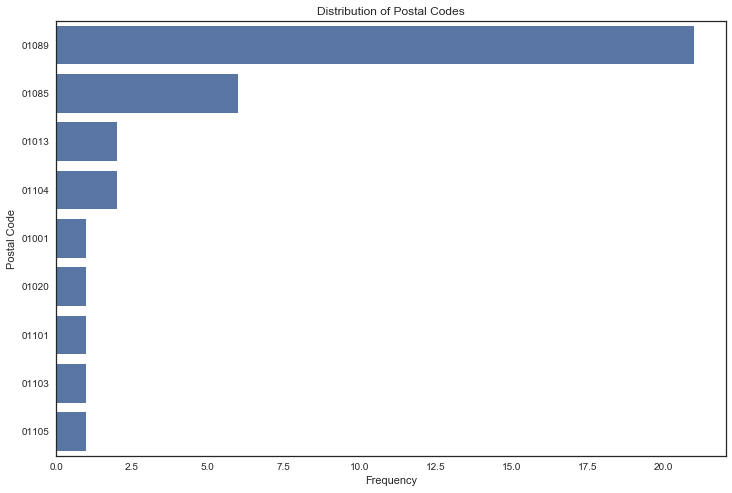

In [7]:
import pandas as pd

# This will show the distribution of postal codes
db = sqlite3.connect("west-springfield.db")
c = db.cursor()
query = '''
select value, count(*) as total from nodes_tags 
where key='postcode' group by value order by total desc;
'''
c.execute(query)
rows = c.fetchall()
df = pd.DataFrame(rows)
df = df.rename(columns={0: 'Postal_Code', 1: 'Frequency'})
df.Postal_Code = df.Postal_Code.astype('category')

plt.figure(figsize=(12,8))
sns.barplot(
    x='Frequency', 
    y='Postal_Code',
    data=df, 
    order=df.Postal_Code.tolist(), 
    color=colors[0])
plt.title('Distribution of Postal Codes')
plt.xlabel('Frequency')
plt.ylabel('Postal Code')
plt.show()

## Amenities

Below is a distribution of the top 10 most prominent amenities in West Springfield.  I was surprised to discover that the number of places of worship in the area outnumber the number of schools.

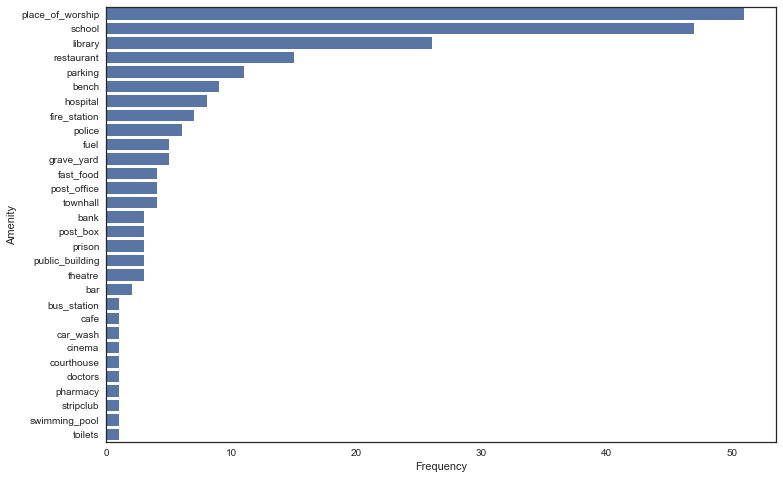

In [8]:
db = sqlite3.connect("west-springfield.db")
c = db.cursor()
query = '''
select value, count(*) as total from nodes_tags
where key='amenity'
group by value order by total desc;
'''
c.execute(query)
rows = c.fetchall()
    
df = pd.DataFrame(rows)
plot_bar(df, x_var='Amenity')   

db.close()

### Restaurants

At first I wasn't going to take a closer look at the types of restaurants in the area since there are less than 20, but my curiousity got the better of me.

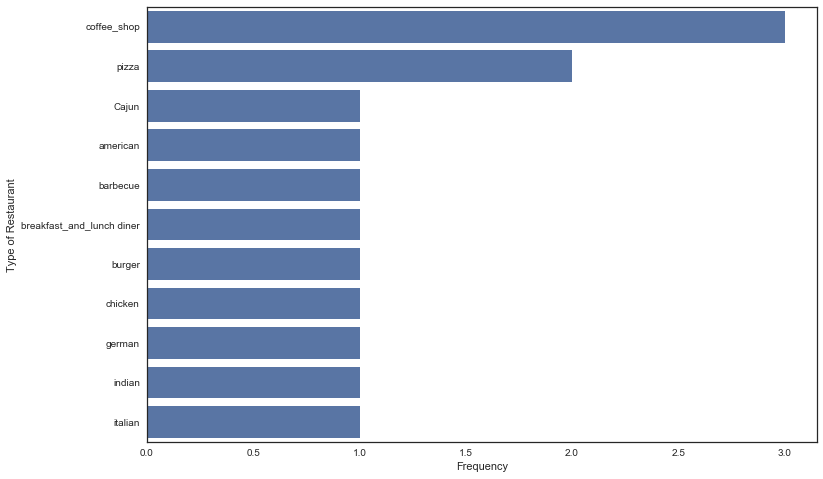

In [13]:
# This will show the distribution of restaurants
db = sqlite3.connect("west-springfield.db")
c = db.cursor()
query = '''
select value, count(*) as total from nodes_tags
where key='cuisine'
group by value order by total desc;
'''
c.execute(query)
rows = c.fetchall()
    
df = pd.DataFrame(rows)
plot_bar(df, x_var='Type of Restaurant')
# display(df)
db.close()

### Shameless Plug

I've heard a lot of chatter about [Mama Mia's Pizzeria](https://www.mymamamiaspizza.com/), but I've never been there. I think it's time to make a visit.

<img src='https://raw.githubusercontent.com/spacecadet84/p3/master/screenshots/mama_mias.png'>

## Distribution of Users

Below are the top 10 map contributers.  It appears the Office of Geographic Information was responsible for the majority of the data.  I hope to see my name among these some day.

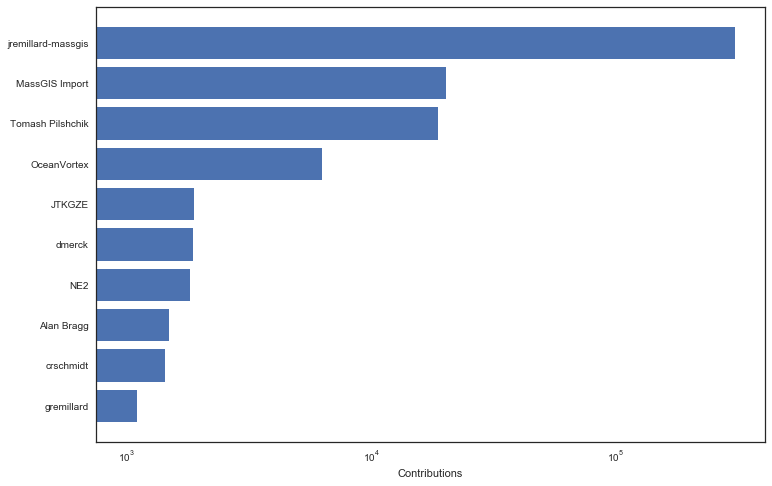

In [10]:
# This will show the distribution of users
db = sqlite3.connect("west-springfield.db")
c = db.cursor()
query = '''
select user, count(*) as total
from (select user from nodes union all select user from ways)
group by user
order by total desc
limit 10;
'''
c.execute(query)
rows = c.fetchall()
    
df = pd.DataFrame(rows)
plt.figure(figsize=(12,8))
x=df[1]
y=range(9,-1,-1)
plt.barh(y,x, log=True)
plt.yticks(y, df.iloc[:10,0])
plt.xlabel('Contributions')
plt.show()  

db.close()

## Individual User Contributions

I was interested in what some of the users actually did to contribute to the project.  It seems MassGIS may have built the dataset initially but I wanted to see how Tomash Pilshchik changed it.  It turns out he focused on  nodes tags by far.



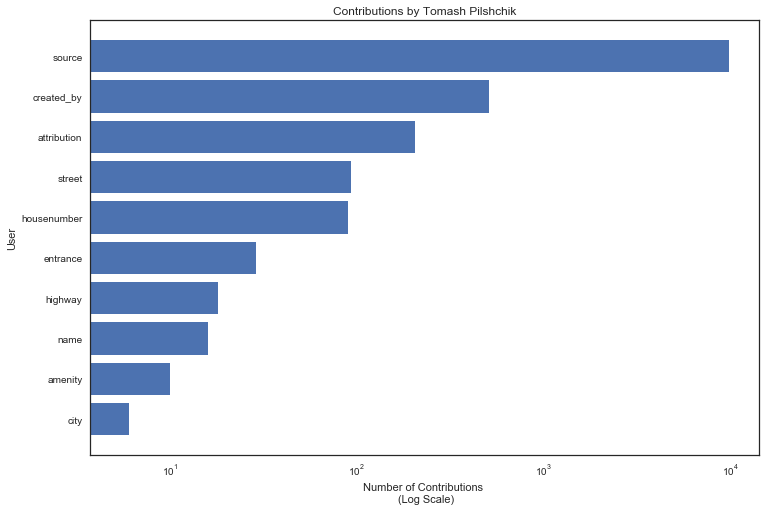

In [11]:
db = sqlite3.connect("west-springfield.db")
c = db.cursor()
query = '''
select key, count(*) as total
from nodes, nodes_tags
where nodes.id = nodes_tags.id and user='Tomash Pilshchik'
group by key
order by total desc
limit 10;
'''
c.execute(query)
rows = c.fetchall()
    
df = pd.DataFrame(rows)

plt.figure(figsize=(12,8))
x=df[1]
y=range(9,-1,-1)
plt.barh(y, x, log=True)
plt.yticks(y, df.iloc[:10,0])
plt.title('Contributions by Tomash Pilshchik')
plt.xlabel('Number of Contributions \n (Log Scale)')
plt.ylabel('User')
plt.show()

db.close()

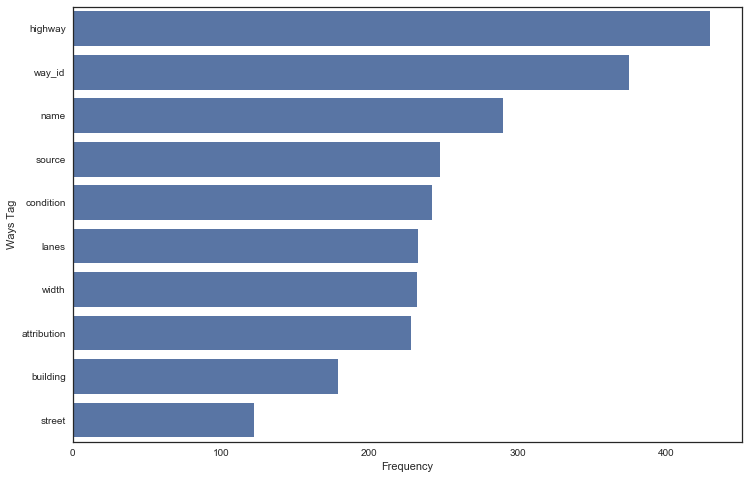

In [12]:
db = sqlite3.connect("west-springfield.db")
c = db.cursor()
query = '''
select key, count(*) as total
from ways, ways_tags
where ways.id = ways_tags.id and user='Tomash Pilshchik'
group by key
order by total desc;
'''
c.execute(query)
rows = c.fetchall()
    
df = pd.DataFrame(rows)  
plot_bar(df, limit=10, x_var='Ways Tag')
db.close()

# Additional Ideas

## Historical Changes

Looking over the data, there are a few areas I'd like to explore more but they would require more historical context.  For instance, Broadway shows up 11 times as a street name but there is no street type.  When I looiked it up on Wikipedia, it said some streets in the Town Common were changed from Broadway to Park Street and Park Avenue.  However, without further clues I would have no idea which streets should be mapped to one or the other.  I'm sure City Hall probably has the historical records but I did not get a chance to go.  This might be worth it for the next user to explore.



## Special Abbreviations

The next step for further exploration would be to check and fix any special abbreviations beyond street types.  For instance the Connecticut River is listed as Connecticut R., but a universal solution wouldn't work there.  If all 'R.' abbreviations were replaced with 'River', it could have unintended consequences.  For instance, the John R. Fausey Elementary School would be changed to the John River Fausey Elementary School.  And while I don't know his middle name, I doubt I'd get that lucky.  There are many opportunities for exploration here.

<img src='https://drive.google.com/uc?export=download&id=0B0YVy8F1XohwRnUwZm9OcnJ2R2s'>

<img src='https://drive.google.com/uc?export=download&id=0B0YVy8F1XohwdG1JNWFBdVBMcjQ'>
<img src='https://drive.google.com/uc?export=download&id=0B0YVy8F1XohwanFlSTRLTnMtbmM'>